# Sommaire

* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) Préparation des données](#ii)
* [III) Nettoyage des données](#iii)
* [IV) Feature engineering et analyse exploratoire](#iv)
* [V) Export](#v)

# Introduction <a class="anchor" id="introduction"></a>
Olist souhaite aboutir à une segmentation des clients que ses équipes d'e-commerce pourront utiliser au quotidien pour leurs campagnes de communication. Dans ce notebook nous allons créer un fichier par client en vue d'élaborer un modèle de clustering.

# I) Importation des données <a class="anchor" id="i"></a>

In [1]:
pip install sqlite3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install shutil

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import shutil

In [4]:
#On créé une copie de la bdd
shutil.copyfile('olist.db', 'olist_backup.db')

'olist_backup.db'

# II) Préparation des données <a class="anchor" id="ii"></a>

In [5]:
#On se connecte à la base de données
conn = sqlite3.connect("olist_backup.db")
cursor = conn.cursor()

In [6]:
#On commence par ajouter de nouvelles colonnes à la table customers
cursor.execute("ALTER TABLE customers ADD COLUMN payment_value REAL")
cursor.execute("ALTER TABLE customers ADD COLUMN review_score INTEGER")
cursor.execute("ALTER TABLE customers ADD COLUMN order_purchase_timestamp TEXT")

#On met à jour les nouvelles colonnes avec les valeurs appropriées
#Ca prend du temps si j'essaie de tout faire d'un coup alors on va faire une requête par colonne
#Paiements
query1 = """
UPDATE customers
SET payment_value = (
    SELECT op.payment_value
    FROM orders o
    JOIN order_pymts op ON o.order_id = op.order_id
    WHERE o.customer_id = customers.customer_id)
"""

#On exécute la requête
cursor.execute(query1)
    
#On vérifie
cursor.execute("SELECT * FROM customers LIMIT 5")
res = cursor.fetchall()

#On affiche
for row in res:
    print(row)

(0, '06b8999e2fba1a1fbc88172c00ba8bc7', '861eff4711a542e4b93843c6dd7febb0', 14409, 'franca', 'SP', 146.87, None, None)
(1, '18955e83d337fd6b2def6b18a428ac77', '290c77bc529b7ac935b93aa66c333dc3', 9790, 'sao bernardo do campo', 'SP', 335.48, None, None)
(2, '4e7b3e00288586ebd08712fdd0374a03', '060e732b5b29e8181a18229c7b0b2b5e', 1151, 'sao paulo', 'SP', 157.73, None, None)
(3, 'b2b6027bc5c5109e529d4dc6358b12c3', '259dac757896d24d7702b9acbbff3f3c', 8775, 'mogi das cruzes', 'SP', 173.3, None, None)
(4, '4f2d8ab171c80ec8364f7c12e35b23ad', '345ecd01c38d18a9036ed96c73b8d066', 13056, 'campinas', 'SP', 252.25, None, None)


In [7]:
#Ca a l'air bon, on valide la modification
conn.commit()

In [8]:
#Je viens de regarder la table dans la bdd, ça a fonctionné
#Du coup on enchaîne avec les reviews
query2 = """
UPDATE customers
SET review_score = (
    SELECT or.review_score
    FROM orders o
    JOIN order_reviews or ON o.order_id = or.order_id
    WHERE o.customer_id = customers.customer_id)
"""

#On exécute la requête
cursor.execute(query2)

In [9]:
#On termine par les dates de commandes
query3 = """
UPDATE customers
SET order_purchase_timestamp = (
    SELECT o.order_purchase_timestamp
    FROM orders o
    WHERE o.customer_id = customers.customer_id)
"""

#On exécute la requête
cursor.execute(query3)

In [10]:
#On valide
conn.commit()

In [4]:
#On créé un df à partir de la table customers modifiée
raw_data = pd.read_sql_query("SELECT * FROM customers", conn)

#On ferme la connexion
conn.close()
raw_data

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,order_purchase_timestamp
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,146.87,4.0,2017-05-16 15:05:35
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,335.48,5.0,2018-01-12 20:48:24
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,157.73,5.0,2018-05-19 16:07:45
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.30,5.0,2018-03-13 16:06:38
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,252.25,5.0,2018-07-29 09:51:30
...,...,...,...,...,...,...,...,...,...
99436,99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,88.78,4.0,2018-04-07 15:48:17
99437,99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,129.06,5.0,2018-04-04 08:20:22
99438,99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,56.04,1.0,2018-04-08 20:11:50
99439,99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,711.07,5.0,2017-11-03 21:08:33


In [5]:
#Colonne index pas nécessaire
raw_data.drop(raw_data.columns[0], axis=1, inplace=True)
raw_data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,order_purchase_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,146.87,4.0,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,335.48,5.0,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,157.73,5.0,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.30,5.0,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,252.25,5.0,2018-07-29 09:51:30
...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,88.78,4.0,2018-04-07 15:48:17
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,129.06,5.0,2018-04-04 08:20:22
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,56.04,1.0,2018-04-08 20:11:50
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,711.07,5.0,2017-11-03 21:08:33


# III) Nettoyage des données <a class="anchor" id="iii"></a>

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  int64  
 3   customer_city             99441 non-null  object 
 4   customer_state            99441 non-null  object 
 5   payment_value             99440 non-null  float64
 6   review_score              98673 non-null  float64
 7   order_purchase_timestamp  99441 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 6.1+ MB


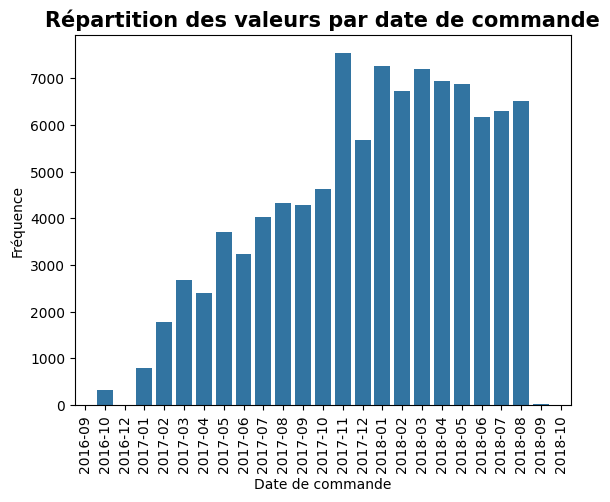

In [7]:
#On va passer order_purchase_timestamp au format date et vérifier la distribution par mois
raw_data['order_purchase_timestamp'] = pd.to_datetime(raw_data['order_purchase_timestamp'])

sns.countplot(x=raw_data['order_purchase_timestamp'].dt.to_period('M').astype(str), data=raw_data, order=raw_data['order_purchase_timestamp'].dt.to_period('M').astype(str).sort_values())

#Titre et axes
plt.title('Répartition des valeurs par date de commande', weight='bold', size=15)
plt.xlabel('Date de commande')
plt.ylabel('Fréquence')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [8]:
#On constate que les mois avant 01-2017 et après 08-2018 sont à peine renseignés (voire pas du tout pour le 11-2016)
#Donc nous allons les retirer de l'analyse
mask = (raw_data['order_purchase_timestamp'].dt.to_period('M') >= '2017-01') & (raw_data['order_purchase_timestamp'].dt.to_period('M') <= '2018-08')
data_filtré = raw_data[mask].reset_index(drop=True)
print(data_filtré['order_purchase_timestamp'].sort_values().head(5))
print()
print(data_filtré['order_purchase_timestamp'].sort_values().tail(5))

18922   2017-01-05 11:56:06
48891   2017-01-05 12:01:20
44073   2017-01-05 12:06:36
1998    2017-01-05 12:09:08
45574   2017-01-05 12:11:23
Name: order_purchase_timestamp, dtype: datetime64[ns]

23101   2018-08-30 10:14:00
39854   2018-08-30 10:24:34
30717   2018-08-30 13:07:46
61329   2018-08-30 15:11:58
92952   2018-08-31 16:13:44
Name: order_purchase_timestamp, dtype: datetime64[ns]


In [9]:
#Quelques clients n'ont pas laissé de reviews, ce n'est pas choquant mais ce sera problématique lors de la modélisation plus tard
#Elles sont peu nombreuses (~750 sur 990 000) donc je décide de supprimer les lignes en question
data_filtré = data_filtré.dropna(subset=['review_score']).reset_index(drop=True)
data_filtré

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,order_purchase_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,146.87,4.0,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,335.48,5.0,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,157.73,5.0,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.30,5.0,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,252.25,5.0,2018-07-29 09:51:30
...,...,...,...,...,...,...,...,...
98325,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,88.78,4.0,2018-04-07 15:48:17
98326,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,129.06,5.0,2018-04-04 08:20:22
98327,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,56.04,1.0,2018-04-08 20:11:50
98328,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,711.07,5.0,2017-11-03 21:08:33


In [10]:
#Recherche d'outliers/valeurs aberrantes
data_filtré.describe()

,customer_zip_code_prefix,payment_value,review_score,order_purchase_timestamp
count,98330.000000,98330.000000,98330.000000,98330
mean,35145.280555,156.908091,4.086942,2018-01-01 22:54:39.259931136
min,1003.000000,0.000000,1.000000,2017-01-05 11:56:06
25%,11320.000000,59.000000,4.000000,2017-09-13 18:38:25.249999872
50%,24412.000000,102.640000,5.000000,2018-01-19 19:19:11
75%,59015.000000,174.100000,5.000000,2018-05-05 09:08:52.750000128
max,99990.000000,13664.080000,5.000000,2018-08-31 16:13:44
std,29819.017278,217.911513,1.346663,NaN


In [11]:
#Par curiosité
data_filtré.loc[data_filtré['payment_value'] == 0]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,order_purchase_timestamp
16152,8eab8f9b3c744b76b65f7a2c0c8f2d6c,e4000306cf2f63714e6bb70dd20a6592,74595,goiania,GO,0.0,1.0,2017-06-08 21:18:45
25368,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a,78065,cuiaba,MT,0.0,1.0,2017-04-20 12:45:34
48204,3532ba38a3fd242259a514ac2b6ae6b6,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,0.0,1.0,2018-08-28 15:26:39
51028,843b211abe7b0264dd4a69eafc5bdf43,677ad9cdca6c47c733f0cc6e23d7bb4c,25625,petropolis,RJ,0.0,4.0,2017-10-26 23:51:35
51728,f2def7f64f36952f2f5a9791f0285f34,cc5aa1b8337e394da54980226bb0f6d4,21040,rio de janeiro,RJ,0.0,4.0,2018-01-24 23:24:14
62261,197a2a6a77da93f678ea0d379f21da0a,6ba987d564bad1f9da8e14b9d3b71c8f,8042,sao paulo,SP,0.0,1.0,2018-08-28 20:05:14
74393,648121b599d98c420ef93f6135f8c80c,9077449283dc1319d5e51fb3159b28e2,29230,anchieta,ES,0.0,5.0,2017-05-27 19:20:24


In [12]:
#Je n'exclue pas la possibilité qu'il s'agisse de commandes avec bons de réduction où le client n'a rien eu à dépenser donc je les conserve
data_filtré.sort_values('payment_value', ascending=False).head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,order_purchase_timestamp
6110,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,13664.08,1.0,2017-09-29 15:24:52
97346,ec5b2ba62e574342386871631fafd3fc,763c8b1c9c68a0229c42c9fc6f662b93,29102,vila velha,ES,7274.88,1.0,2018-07-15 14:49:44
13290,c6e2731c5b391845f6800c97401a43a9,dc4802a71eae9be1dd28f5d788ceb526,79042,campo grande,MS,6929.31,5.0,2017-02-12 20:37:36
3856,3fd6777bbce08a352fddd04e4a7cc8f6,ff4159b92c40ebe40454e3e6a7c35ed6,17506,marilia,SP,6726.66,5.0,2017-05-24 18:14:34
85393,05455dfa7cd02f13d132aa7a6a9729c6,4007669dec559734d6f53e029e360987,35501,divinopolis,MG,6081.54,1.0,2017-11-24 11:03:35
26976,df55c14d1476a9a3467f131269c2477f,da122df9eeddfedc1dc1f5349a1a690c,28970,araruama,RJ,4950.34,5.0,2017-04-01 15:58:40
44248,e0a2412720e9ea4f26c1ac985f6a7358,5d0a2980b292d049061542014e8960bf,74210,goiania,GO,4809.44,1.0,2018-07-12 12:08:36
11904,24bbf5fd2f2e1b359ee7de94defc4a15,eebb5dda148d3893cdaf5b5ca3040ccb,9341,maua,SP,4764.34,4.0,2017-04-18 18:50:13
40194,3d979689f636322c62418b6346b1c6d2,48e1ac109decbb87765a3eade6854098,58038,joao pessoa,PB,4681.78,5.0,2018-06-22 12:23:19
63744,1afc82cd60e303ef09b4ef9837c9505c,edde2314c6c30e864a128ac95d6b2112,2995,sao paulo,SP,4513.32,5.0,2018-08-03 21:10:16


In [13]:
#Une commande se distingue un peu du lot mais le montant ne me choque pas pour autant, on conserve également
#Ajout d'une colonne jours_depuis_cmd, en se positionnant au 2018-09-01
data_filtré = data_filtré.copy()
data_filtré['jours_depuis_cmd'] = (pd.to_datetime('2018-09-01') - data_filtré['order_purchase_timestamp']).dt.days
data_filtré

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,order_purchase_timestamp,jours_depuis_cmd
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,146.87,4.0,2017-05-16 15:05:35,472
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,335.48,5.0,2018-01-12 20:48:24,231
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,157.73,5.0,2018-05-19 16:07:45,104
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.30,5.0,2018-03-13 16:06:38,171
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,252.25,5.0,2018-07-29 09:51:30,33
...,...,...,...,...,...,...,...,...,...
98325,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,88.78,4.0,2018-04-07 15:48:17,146
98326,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,129.06,5.0,2018-04-04 08:20:22,149
98327,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,56.04,1.0,2018-04-08 20:11:50,145
98328,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,711.07,5.0,2017-11-03 21:08:33,301


In [14]:
#Un fichier par client avec nombre de commandes, panier moyen, review score moyen et nombre de jours depuis la dernière commande
data_gb = data_filtré.groupby('customer_unique_id').agg(
    nb_commandes=('customer_id', 'count'),
    panier_moyen=('payment_value', 'mean'),
    review_score_moyen=('review_score', lambda x: round(x.mean(), 1)),
    jours_depuis_derniere_cmd=('jours_depuis_cmd', 'min'),
    date_derniere_cmd=('order_purchase_timestamp', 'max') #Je viens du futur et cette colonne sera nécessaire pour l'ARI
).reset_index()

data_gb

,customer_unique_id,nb_commandes,panier_moyen,review_score_moyen,jours_depuis_derniere_cmd,date_derniere_cmd
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,5.0,113,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,4.0,116,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,86.22,3.0,539,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,4.0,323,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,5.0,290,2017-11-14 19:45:42
...,...,...,...,...,...,...
95059,fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,5.0,449,2017-06-08 21:00:36
95060,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,4.0,264,2017-12-10 20:07:56
95061,ffff371b4d645b6ecea244b27531430a,1,112.46,5.0,570,2017-02-07 15:49:16
95062,ffff5962728ec6157033ef9805bacc48,1,133.69,5.0,121,2018-05-02 15:17:41


# IV) Analyse exploratoire <a class="anchor" id="iv"></a>

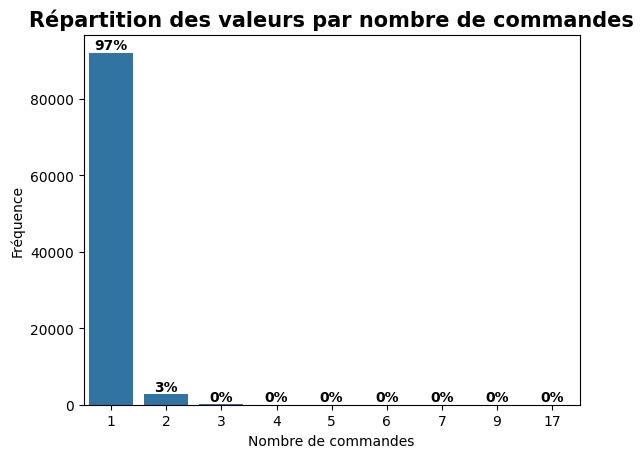

In [15]:
g1 = sns.countplot(x='nb_commandes', data=data_gb)

#Titre et axes
g1.set_title('Répartition des valeurs par nombre de commandes', weight='bold', size=15)
g1.set_xlabel('Nombre de commandes')
g1.set_ylabel('Fréquence')

#Pour afficher les pourcentages au-dessus des barres
for p in g1.patches:
    percentage = round((p.get_height() / len(data_gb)) * 100)
    g1.annotate(f'{percentage}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points', weight='bold', size=10)
plt.show()

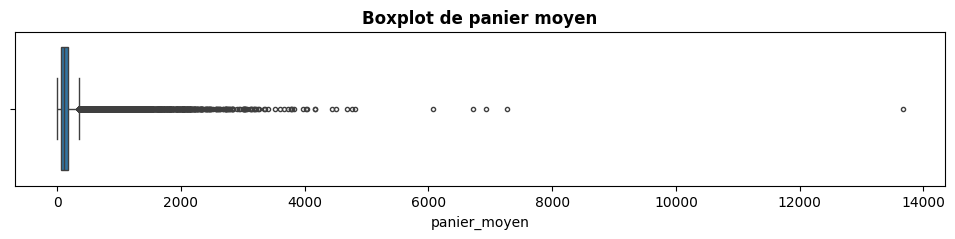

In [16]:
#97% des clients n'ont passé qu'une seule commande
plt.figure(figsize=(12,2))
g2 = sns.boxplot(x=data_gb['panier_moyen'], fliersize=3)
g2.set_title('Boxplot de panier moyen', weight='bold')
plt.show()

In [17]:
#Beaucoup d'outliers, boxplot peu lisible
data_gb['panier_moyen'].describe()

count    95064.000000
mean       157.299137
std        218.131979
min          0.000000
25%         59.467500
50%        103.050000
75%        174.280000
max      13664.080000
Name: panier_moyen, dtype: float64

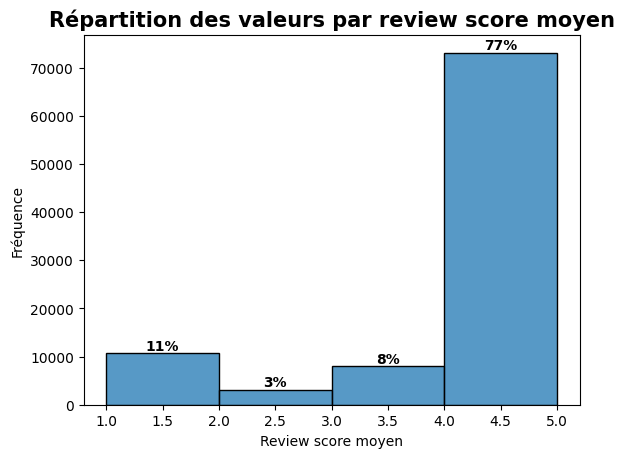

In [18]:
#75% des paniers moyens sont inférieurs à 174.3 réals
g3 = sns.histplot(x='review_score_moyen', data=data_gb, bins=4)

#Titre et axes
g3.set_title(f'Répartition des valeurs par review score moyen', weight='bold', size=15)
g3.set_xlabel('Review score moyen')
g3.set_ylabel('Fréquence')

#Pour afficher les pourcentages au-dessus des barres
for p in g3.patches:
    percentage = round((p.get_height() / len(data_gb)) * 100)
    g3.annotate(f'{percentage}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points', weight='bold', size=10)
plt.show()

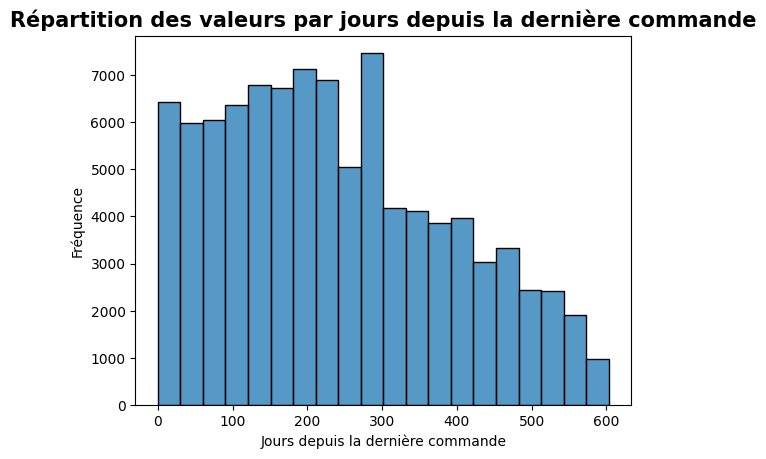

In [19]:
#77% des review score moyens sont supérieurs ou égaux à 4
g4 = sns.histplot(x='jours_depuis_derniere_cmd', data=data_gb, bins=20)

#Titre et axes
g4.set_title(f'Répartition des valeurs par jours depuis la dernière commande', weight='bold', size=15)
g4.set_xlabel('Jours depuis la dernière commande')
g4.set_ylabel('Fréquence')
plt.show()

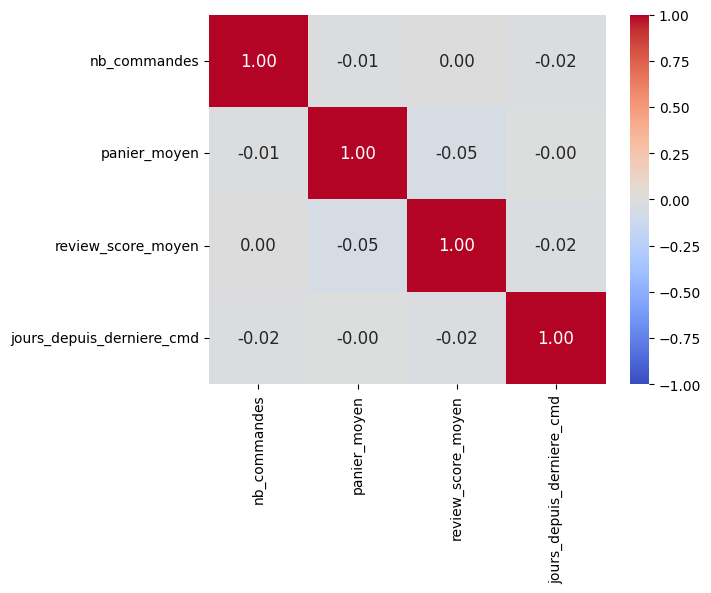

In [20]:
#Beaucoup plus de valeurs dans les 300 derniers jours
#Comme 97% des clients n'ont passé qu'une seule commande, cela montre surtout qu'il y a beaucoup de nouveaux clients et que le volume de commandes augmente
#On va s'intéresser à la corrélation entre les variables
sns.heatmap(data_gb.iloc[:, 1:-1].corr(), vmin=-1, annot=True, fmt='.2f', cmap="coolwarm", annot_kws={"size": 12})
plt.show()

Manifestement pas de corrélation entre nos variables.
# V) Export <a class="anchor" id="v"></a>

In [21]:
data_gb.to_pickle('data_gb.pkl')